In [87]:
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.pyplot import figure
import scipy.stats
import scipy
import math
import random
from scipy.stats import binom_test
from scipy.stats import kstest
from scipy.stats import norm
import sys 
from scipy.stats import binom
import matplotlib.pyplot as plt
import pandas as pd
from datetime import datetime
from scipy.stats import poisson
import random
import numpy as np
from numpy.random import random
import matplotlib.dates as mdates
from matplotlib.ticker import MaxNLocator



def clopper_pearson(x, n, alpha=0.05):
    """Estimate the confidence interval for a sampled Bernoulli random
    variable.
    `x` is the number of successes and `n` is the number trials (x <=
    n). `alpha` is the confidence level (i.e., the true probability is
    inside the confidence interval with probability 1-alpha). The
    function returns a `(low, high)` pair of numbers indicating the
    interval on the probability.
    """
    
    b = scipy.stats.beta.ppf
    lo = b(alpha / 2, x, n - x + 1)
    hi = b(1 - alpha / 2, x + 1, n - x)
    return 0.0 if math.isnan(lo) else lo, 1.0 if math.isnan(hi) else hi

class Model:
    def __init__(self):
        self.df = self.readindata() # processes our data into one dataframe
        self.cumprobdf = self.generatecumdata() # generates a cumulative probability dataframe
        self.binomialestimates = self.generatefinalbinomest() # returns final binomial estimates given observed all the data

    def clopper_pearson(self,x, n, alpha=0.05):
        """Estimate the confidence interval for a sampled Bernoulli random
        variable.
        `x` is the number of successes and `n` is the number trials (x <=
        n). `alpha` is the confidence level (i.e., the true probability is
        inside the confidence interval with probability 1-alpha). The
        function returns a `(low, high)` pair of numbers indicating the
        interval on the probability.
        """
        
        b = scipy.stats.beta.ppf
        lo = b(alpha / 2, x, n - x + 1)
        hi = b(1 - alpha / 2, x + 1, n - x)
        return 0.0 if math.isnan(lo) else lo, 1.0 if math.isnan(hi) else hi


    def readindata(self):
        k1 = pd.read_csv('keywordlist1.txt',sep = ';',header=None)
        keys = k1[0]
        keys1 = keys.to_list()
        k2 = pd.read_csv('keywordlist2.txt',sep = ';',header=None)
        keys2 = k2[0].to_list()
        
        df1 = pd.read_csv('combined.csv', sep = ';', header = None,on_bad_lines='skip',names = ['Link'] + keys1 + ['Date','a26'])
        df1 = df1.dropna(subset = 'Date')
        
        df2 = pd.read_csv('set2_combined.csv', sep = ';', header = None,on_bad_lines='skip',names = ['Link'] + keys2 + ['Date','b26'])
        df2 = df2.dropna(subset = 'Date')

        #Perform outer join
        df = pd.merge(df1,df2,how = 'outer')
        df['Date'] = [elem.split(sep='T')[0] for elem in df['Date']]
        df['Date'] = [datetime.strptime(elem,"%Y-%m-%d") for elem in df['Date']]
        #df['Date'] = [elem.strftime('%Y-%m') for elem in df['Date']]
        #Convert date format

        #Create a counter of the number of articles so when resampling, we attain the number of articles per day
        df['NumOfArticles'] = [1 for i in range(len(df['Date']))]

        #Drop columns a26 and b26 and the list of links
        del df['a26']
        del df['b26']
        del df['Link']

        #Set index to equal date and get rid of that column
        df.index = df['Date']
        del df['Date']

        #For each row, if the element appears in the article set equal to 1 else 0
        for column in list(df):
            df[column] = [1 if elem>0 else 0 for elem in df[column]]
            
        #Group by day
        df = df.resample('D').sum()

        #Select start and end dates
        df =df.loc['2022-02-02':'2023-2-10']
        print("Process our DataFrame:                   Successfully parsed and formatted our data")
        df.to_csv('./processeddata.csv')
        return(df) # returns processed dataframe

    def generatecumdata(self):
        #Create a dataframe that computes the cumulative probability up until that date of a keyword occuring
        cumprob = self.df.copy()

        #Generates cumulative sum
        for column in list(cumprob)[:-1]:
            cumprob[column] = [sum(cumprob[column][:i+1])/sum(cumprob['NumOfArticles'][:i+1]) for i in range(0,len(cumprob[column]))]
        cumprob['NumOfArticles'] =np.cumsum(cumprob['NumOfArticles'])

        #Compute Binomial Estimates
        binomestimates = [sum(self.df[column])/sum(self.df['NumOfArticles']) for column in list(self.df)[:-1]]

        #Check that estimates line up with cumulative probaiblities at the end of the dataframe
        for i in range(0,len(cumprob.iloc[-1][:-1])):
            if (cumprob.iloc[-1][:-1][i] != binomestimates[i]):
                print(False)
                break
            if i == len(cumprob.iloc[-1][:-1])-1:
                print("""Process our Cumulative Probabilities DataFrame:     TEST-
                    Binomial Probabilities is the same as last row of cumulative probabilities""")
                #If test completes successfully
        return(cumprob) # returns a dataframe containing cumulative probabilities
        
    def generatefinalbinomest(self):
        return([sum(self.df[column])/sum(self.df['NumOfArticles']) for column in list(self.df)[:-1]])
    
    def MA_mean_df(self,K):
        #Generate moving average of observations
        movingaveragedf = self.df.copy()
        return(pd.DataFrame(self.df).rolling(K,center = True)).mean()

    def MA_sd_df(self,K):
        #Generate moving average of standard deviations
        movingsddf = self.df.copy()
        return(pd.DataFrame(self.df).rolling(K,center=True).std())

    def MA_binomest_CI_plot(self, K=30,alpha=0.05):
        #Generates plot for a given column
        columns = list(self.df)[0:-1]
        k = 0 
        column = columns
        for column in columns:
            rollingbinomestimatesdf = self.cumprobdf

            rolling_binom_estimate = list(rollingbinomestimatesdf[column])

            CI_lower = []
            CI_upper = []

            for k in range(len(rolling_binom_estimate)):
                total = list(self.cumprobdf['NumOfArticles'])[k]
                successes = total*rolling_binom_estimate[k]
                lo, hi = self.clopper_pearson(successes, total)
                CI_lower.append(lo)
                CI_upper.append(hi)
            
            figure(figsize=(10, 10), dpi=160)
            fig, ax1 = plt.subplots()
            ax1.xaxis.set_major_formatter(mdates.DateFormatter('%b')) # Only plot the month
            ax1.set_xlabel('Date')
            ax2 = ax1.twinx()
            #Plot binomestiamtes
            ax1.plot(self.df.index.values, rolling_binom_estimate, label = "Probability Estimate")
            #Plot upper and lower CI
            ax1.plot(self.df.index.values,CI_lower , label = "Upper Clopper Pearson CI bound")
            ax1.plot(self.df.index.values,CI_upper , label = "Lower Clopper Pearson CI bound")
            #Plot mean of our data
            ax2.bar(self.df.index.values, self.MA_mean_df(30)[column] ,width = 0.3)
            ax2.set_ylabel('Frequency')
            ax1.set_ylabel('Probability')
            ax1.legend(loc="upper right")
            plt.savefig('./Plots/BinomialProbEstimates/' + column)
            plt.show()
    
    def CI_of_estimates_plot(self):
        lot = []
        hit = []
        # For each of the final binomial estimates
        for prob in self.binomialestimates:
            successes = prob*self.cumprobdf['NumOfArticles'][-1]
            total = self.cumprobdf['NumOfArticles'][-1]
            lo, hi = self.clopper_pearson(successes, total)
            lot.append(lo)
            hit.append(hi)

        y=[]
        for i in range(len(self.binomialestimates)):
            y.append((lot[i],hit[i]))
        x = [i for i in range(len(self.binomialestimates))]
        plt.scatter(x,self.binomialestimates, s = 4)
        plt.plot((x,x),([i for (i,j) in y], [j for (i,j) in y]),c='black')
        plt.xlabel("Category")
        plt.ylabel('Probability Estimate')
        plt.savefig('./Plots/CI_estimates/CI_estimates.png')
        plt.show()
        #remember to define p first!

    #remember to define p first!

    def binplot2(self):
        columns = list(self.df)[0:-1]
        k = 0 
        column = columns
        for column in columns:
            #Set up plots with two axis
            fig, ax2 = plt.subplots()
            ax1 = ax2.twinx()
            
            #Compute histogram with weights i.e. the pdf
            #weights = np.ones_like(self.df[column]) / list(self.cumprobdf["NumOfArticles"])[-1]
            labels, counts = np.unique(self.df[column], return_counts=True)
            counts = counts/list(self.cumprobdf["NumOfArticles"])[-1]
            ax1.bar(labels, counts, align='center',width = 0.4,alpha = 0.7)
            #ax1.gca().set_xticks(labels)
            #ax1.hist(self.df[column], weights=weights, align = 'center')
            
            #Compute the binomial pdf
            p_hat = np.mean(self.df[column])/list(self.df["NumOfArticles"])[-1]
            # n is fixed
            n = list(self.df["NumOfArticles"])[-1]
            # defining list of r values
            r_values = list(range(0,max(self.df[column])+1))
            # list of pmf values
            dist = [binom.pmf(r, n, p_hat) for r in r_values ]
            # plotting the graphs
            ax1.xaxis.set_major_locator(MaxNLocator(integer=True))
            ax1.set_xlabel('Frequency')

            
            ax1.set_title(column)
            ax1.set_ylabel("Histogram Density")
            
            ax2.plot(r_values, dist,"r-")
            ax2.set_ylabel("Probability Density")

            ax1_ylims = ax1.axes.get_ylim()           # Find y-axis limits set by the plotter
            ax1_yratio = ax1_ylims[0] / ax1_ylims[1]  # Calculate ratio of lowest limit to highest limit

            ax2_ylims = ax2.axes.get_ylim()           # Find y-axis limits set by the plotter
            ax2_yratio = ax2_ylims[0] / ax2_ylims[1]  # Calculate ratio of lowest limit to highest limit


            # If the plot limits ratio of plot 1 is smaller than plot 2, the first data set has
            # a wider range range than the second data set. Calculate a new low limit for the
            # second data set to obtain a similar ratio to the first data set.
            # Else, do it the other way around

            if ax1_yratio < ax2_yratio: 
                ax2.set_ylim(bottom = ax2_ylims[1]*ax1_yratio)
            else:
                ax1.set_ylim(bottom = ax1_ylims[1]*ax2_yratio)

            plt.tight_layout()
            plt.savefig('./Plots/Histograms/' + column)
            plt.show()

    def plottingcumproball(self):
        cols = list(self.cumprobdf)
    
        figure(figsize=(10, 10), dpi=160)
        fig, ax1 = plt.subplots()
        ax1.xaxis.set_major_formatter(mdates.DateFormatter('%b'))
        for i in range(0,len(cols)-1):
            #plt.plot(cumprobdf1['Date'], cumprobdf1[cols[min(i,23)]])
            plt.rcParams["figure.figsize"] = [7.50, 3.50]
            plt.rcParams["figure.autolayout"] = True

            
            #color = 'red'
            
            ax1.set_xlabel('Date')
            ax1.set_ylabel('Cumulative Probabilities')
            ax1.plot(self.cumprobdf.index.values, self.cumprobdf[cols[i]])
            ax1.tick_params(axis='y')
        ax2 = ax1.twinx()

        color = 'blue'
        ax2.set_ylabel('KeywordTotal')
        ax2.plot(self.cumprobdf.index.values, self.cumprobdf[cols[-1]], color=color)
        ax2.tick_params(axis='y', labelcolor=color)
        plt.savefig('.\Plots\Cumproball\plot.png')
        plt.show()


    def data_run_prob_plot(self,K,alpha):
        df = self.df
        for ID in list(df):
            p_est_array = []
            df1 = df.rolling(K,center= True).mean()/K
            df1 = df1.dropna(axis = 0)
            p_est_array = np.array(df1[ID])

            #generate confidence intervals:
            z = norm.ppf(alpha)
            np_p = np.array(p_est_array)
            CI_lower = []
            CI_upper = []
            fig, ax1 = plt.subplots()
            for i in np_p:
                successes = i * len(df)
                total = len(df)
                lo, hi = clopper_pearson(successes, total)
                CI_lower.append(lo)
                CI_upper.append(hi)

            ax1.xaxis.set_major_formatter(mdates.DateFormatter('%b'))

            ax1.plot(df1.index.values, np_p, label = "Probability Estimate")
            ax1.plot(df1.index.values,CI_lower , label = "L CI")
            ax1.plot(df1.index.values,CI_upper , label = "U CI")
            ax1.set_xlabel('Date')
            ax1.set_ylabel('Binomial Probability Estimate')
            plt.legend()
            ax1.legend(loc='center left', bbox_to_anchor=(1, 0.5))
            plt.title('Binomial Estimate for ' + str(ID))
            plt.savefig('.\Plots\BinomialProbSlidingWindow\BPE' +str(ID) +'.png')
            plt.show()
    

In [88]:
A = Model()

Process our DataFrame:                   Successfully parsed and formatted our data
Process our Cumulative Probabilities DataFrame:     TEST-
                    Binomial Probabilities is the same as last row of cumulative probabilities


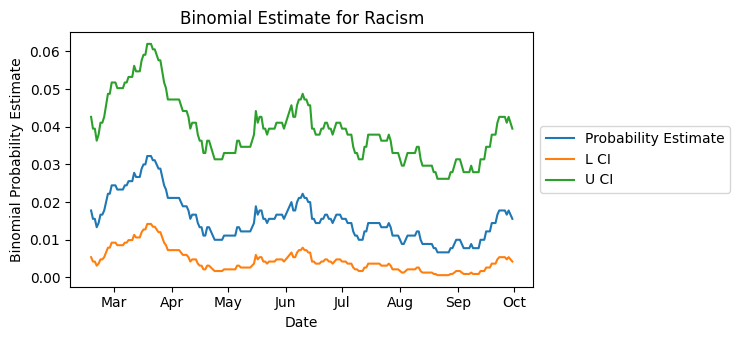

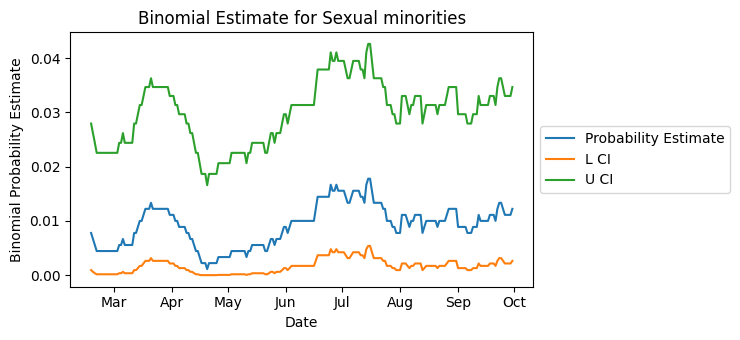

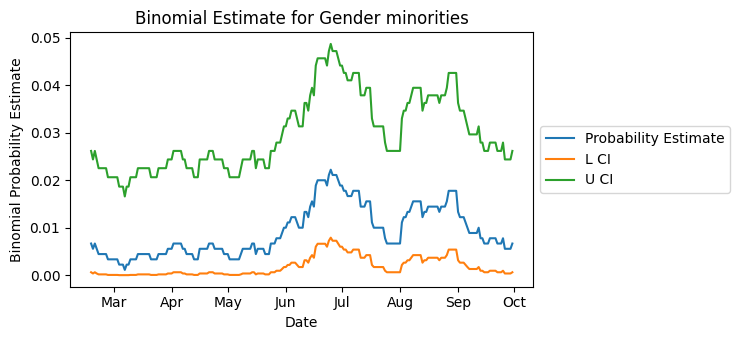

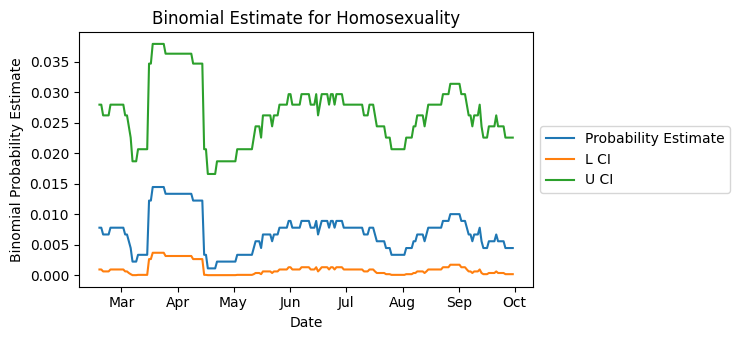

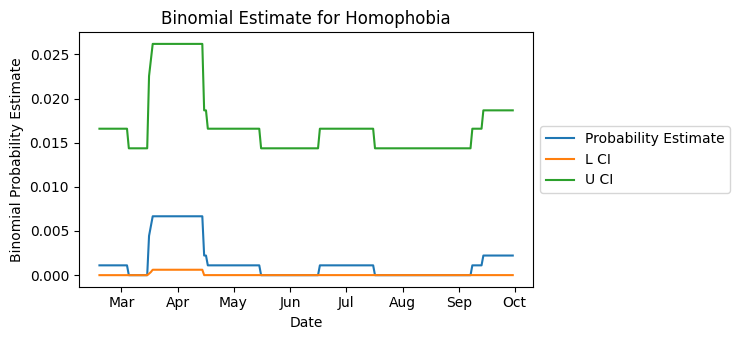

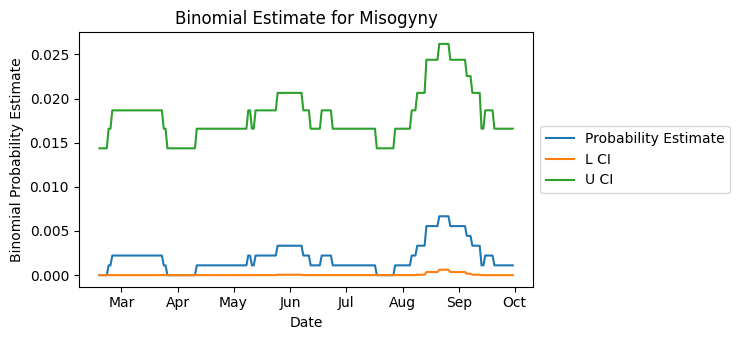

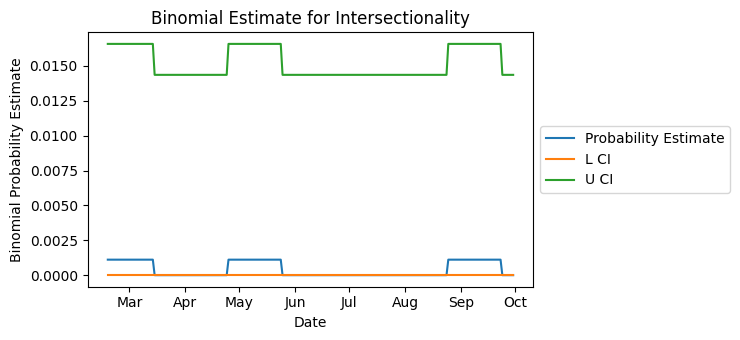

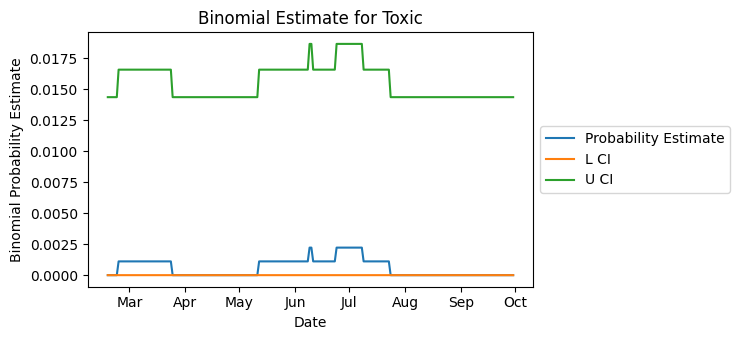

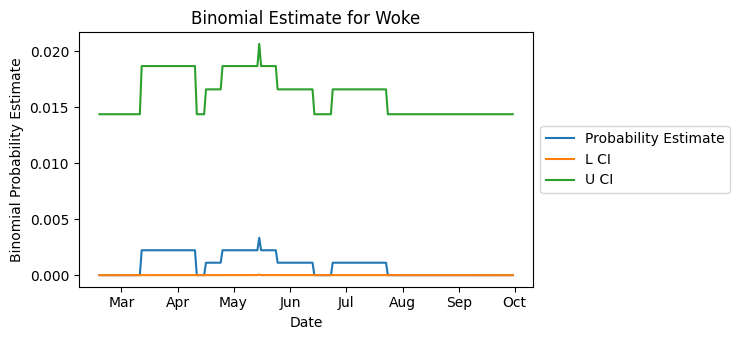

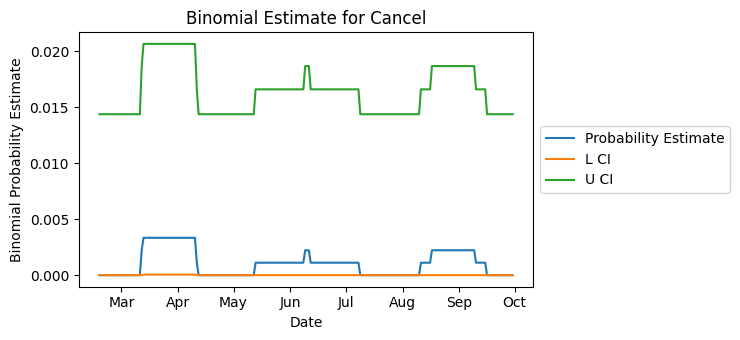

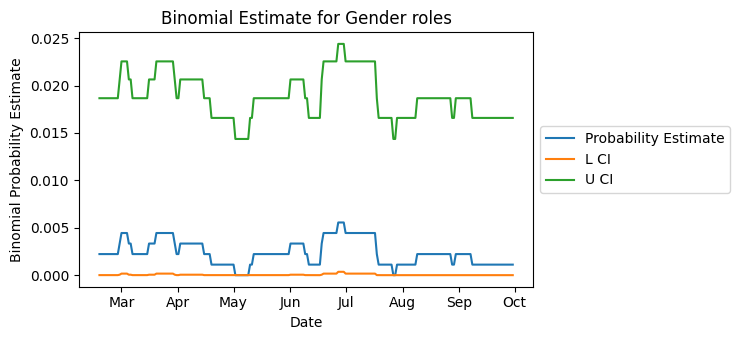

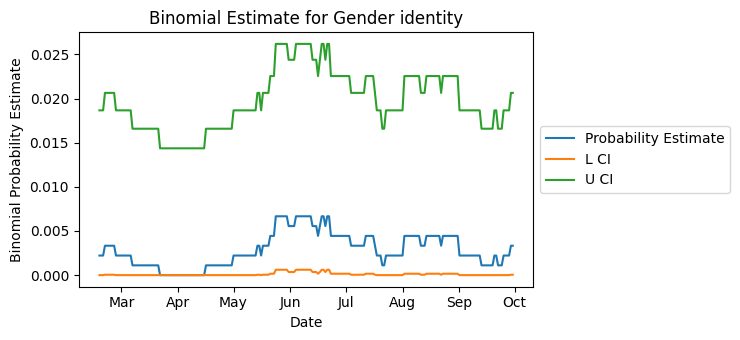

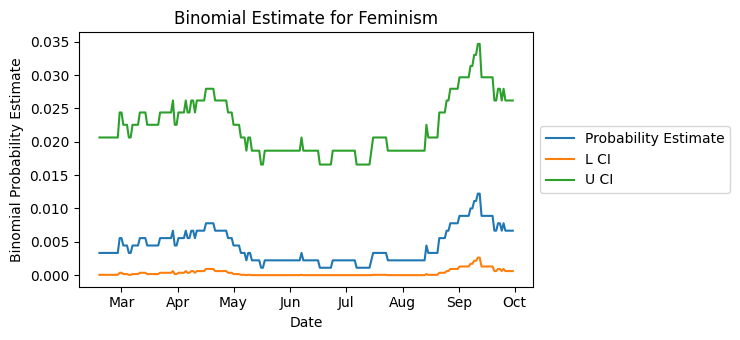

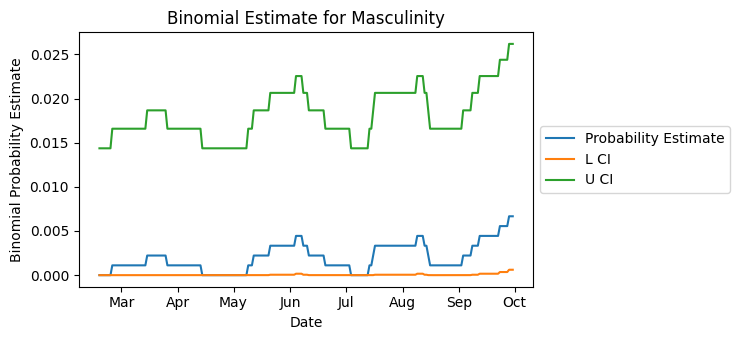

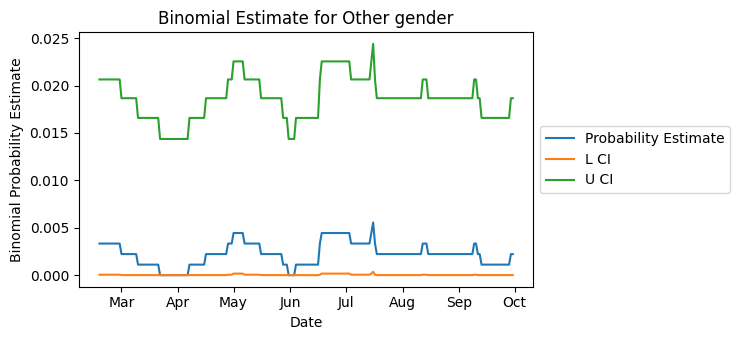

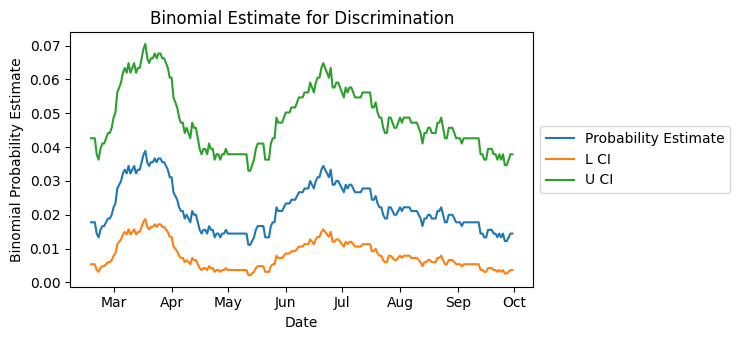

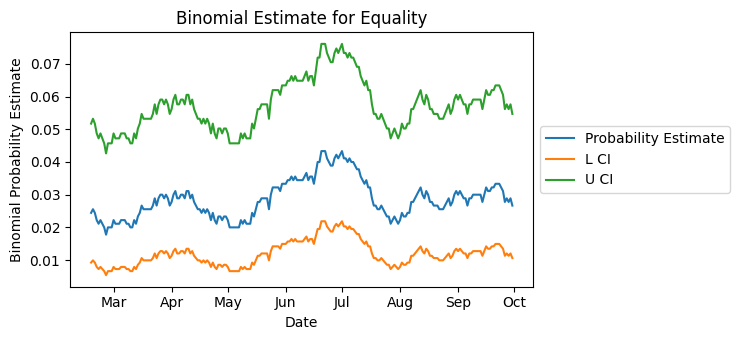

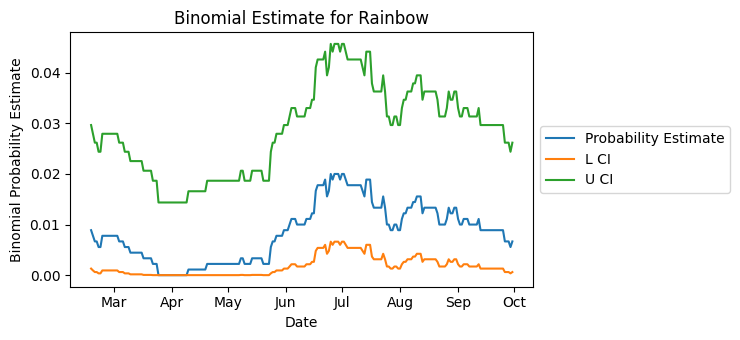

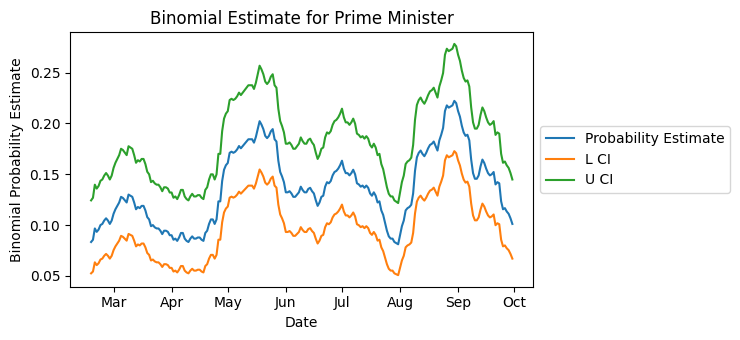

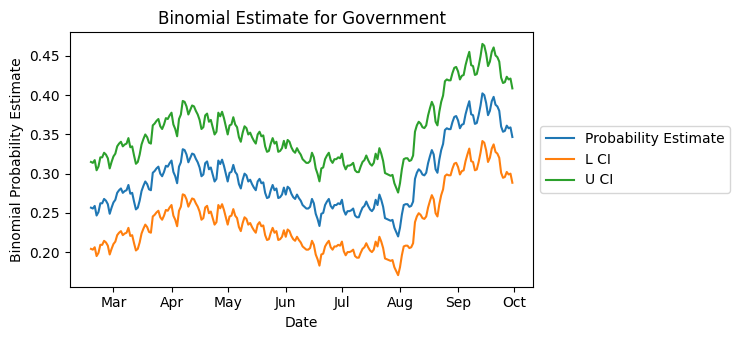

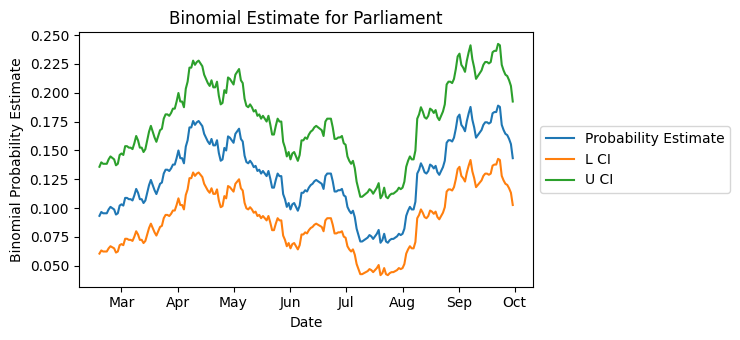

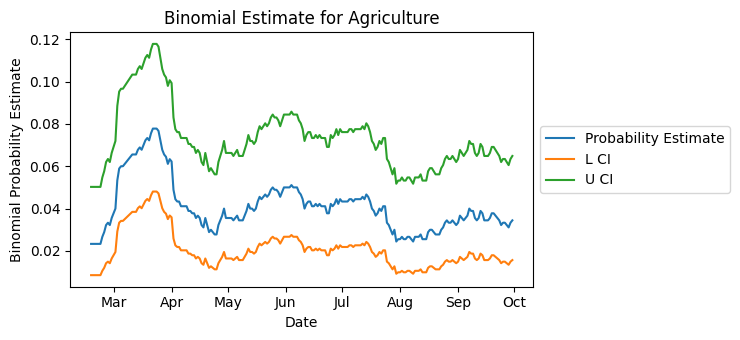

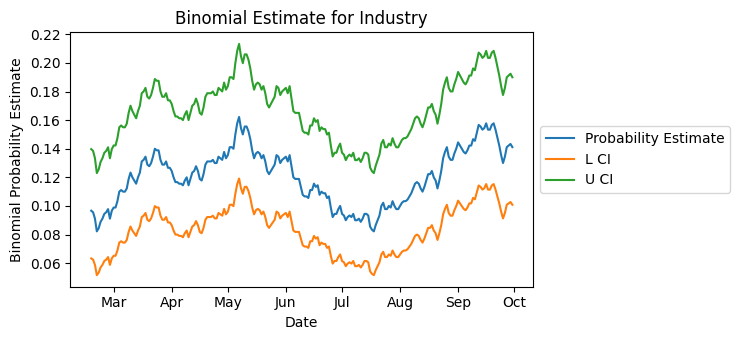

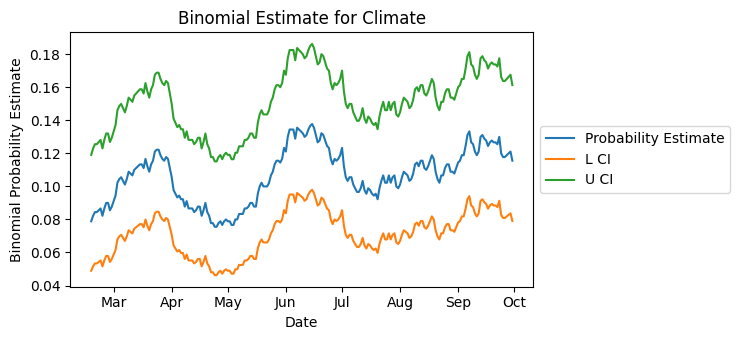

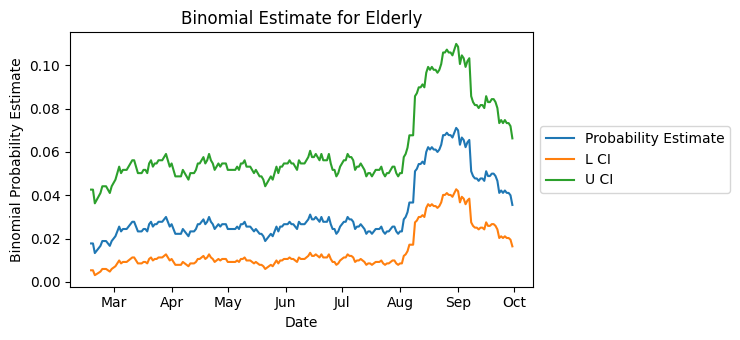

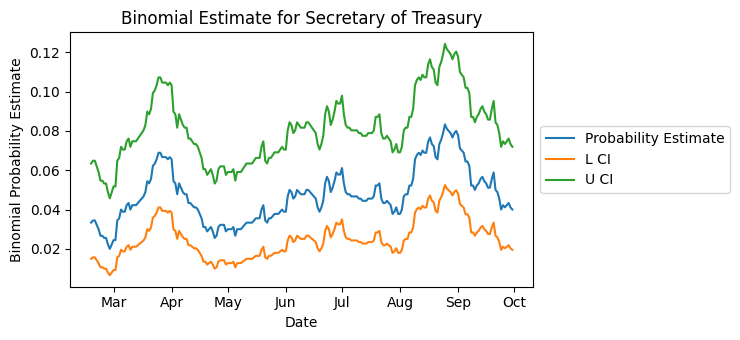

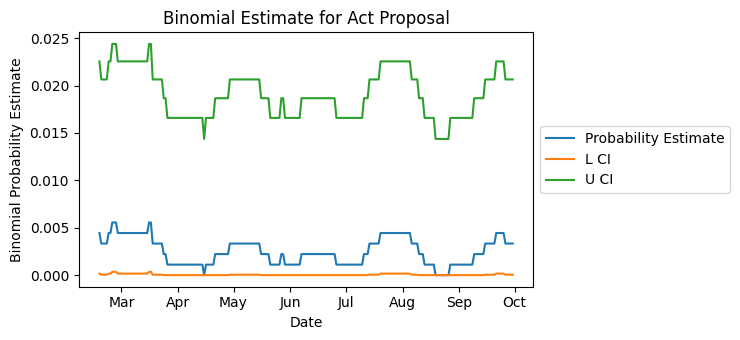

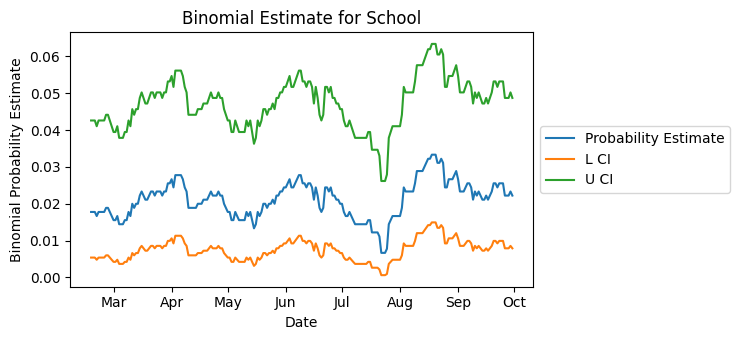

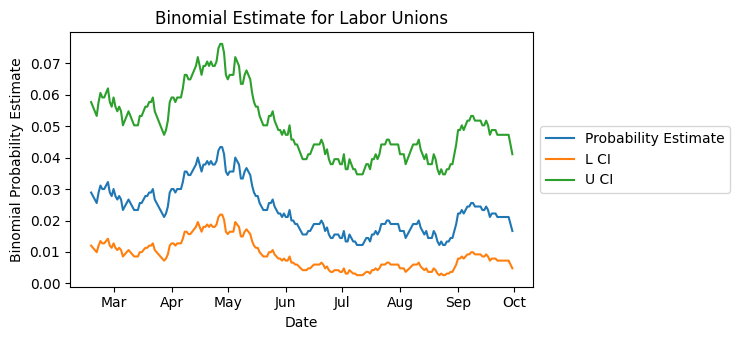

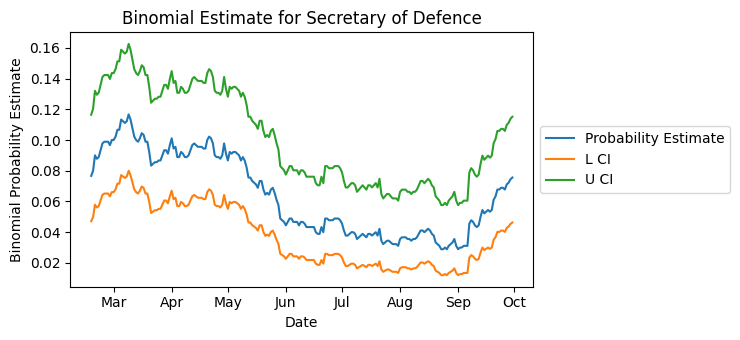

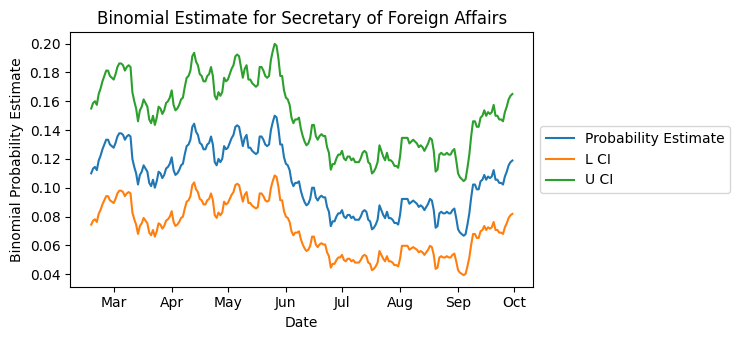

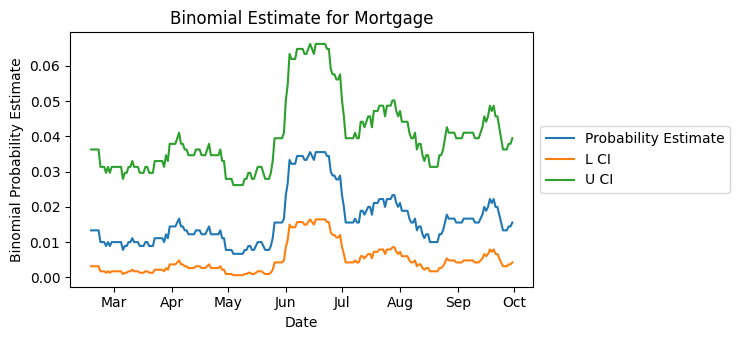

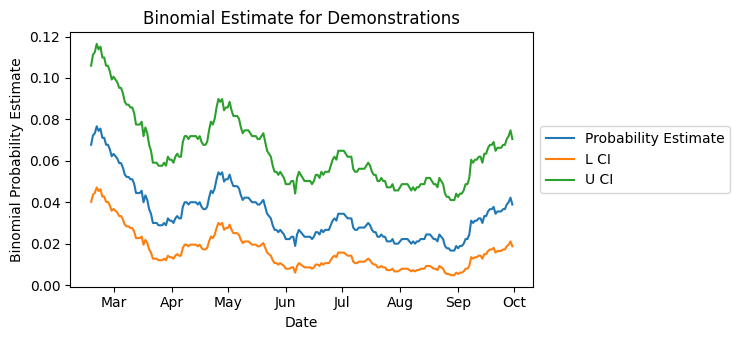

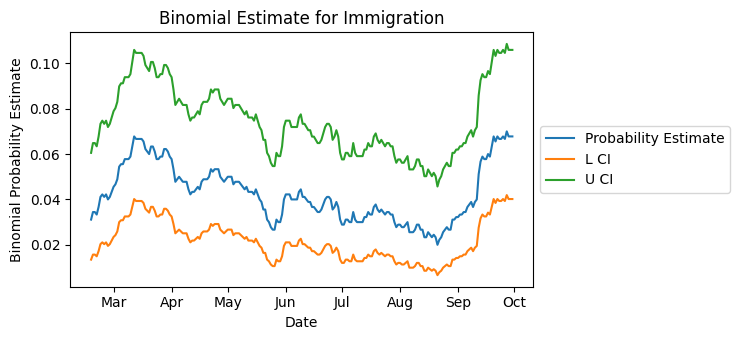

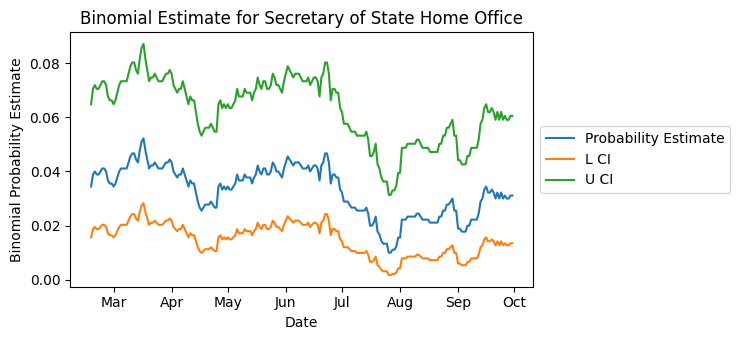

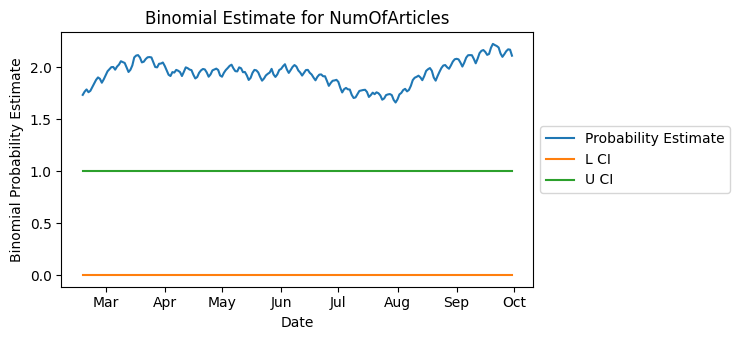

In [90]:
A.data_run_prob_plot(30,0.05)

In [32]:
df = Model().df


Process our DataFrame:                   Successfully parsed and formatted our data
Process our Cumulative Probabilities DataFrame:     TEST-
                    Binomial Probabilities is the same as last row of cumulative probabilities


,Racism,Sexual minorities,Gender minorities,Homosexuality,Homophobia,Misogyny,Intersectionality,Toxic,Woke,Cancel,...,Act Proposal,School,Labor Unions,Secretary of Defence,Secretary of Foreign Affairs,Mortgage,Demonstrations,Immigration,Secretary of State Home Office,NumOfArticles
Date,,,,,,,,,,,,,,,,,,,,,
2022-02-02,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2022-02-03,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2022-02-04,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2022-02-05,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2022-02-06,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2022-10-10,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2022-10-11,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2022-10-12,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [28]:
A= Model()

Process our DataFrame:                   Successfully parsed and formatted our data
Process our Cumulative Probabilities DataFrame:     TEST-
                    Binomial Probabilities is the same as last row of cumulative probabilities


In [11]:
df = A.cumprobdf

In [16]:
df[['Racism','NumOfArticles']]

,Racism,NumOfArticles
Date,,
2022-02-02,0.038462,52
2022-02-03,0.023810,84
2022-02-04,0.033333,150
2022-02-05,0.030928,194
2022-02-06,0.025316,237
...,...,...
2022-10-10,0.008395,14533
2022-10-11,0.008359,14595
2022-10-12,0.008382,14674


<Figure size 1600x1600 with 0 Axes>

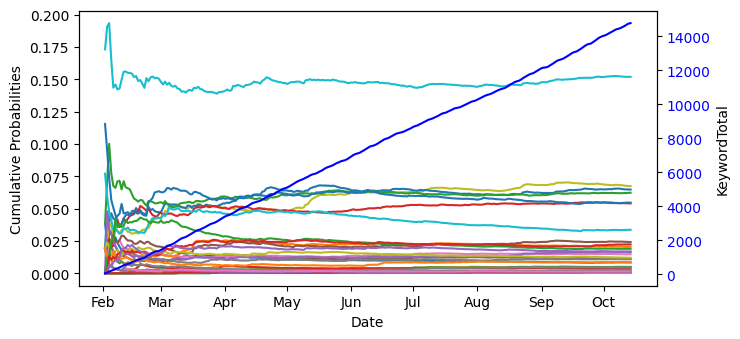

In [29]:
A.plottingcumproball()

In [7]:
A.cumprobdf

,Racism,Sexual minorities,Gender minorities,Homosexuality,Homophobia,Misogyny,Intersectionality,Toxic,Woke,Cancel,...,Act Proposal,School,Labor Unions,Secretary of Defence,Secretary of Foreign Affairs,Mortgage,Demonstrations,Immigration,Secretary of State Home Office,NumOfArticles
Date,,,,,,,,,,,,,,,,,,,,,
2022-02-02,0.038462,0.019231,0.019231,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.019231,0.000000,0.019231,0.076923,0.115385,0.019231,0.000000,0.000000,0.000000,52
2022-02-03,0.023810,0.023810,0.011905,0.011905,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.011905,0.000000,0.023810,0.059524,0.095238,0.011905,0.011905,0.000000,0.000000,84
2022-02-04,0.033333,0.026667,0.013333,0.006667,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.006667,0.006667,0.020000,0.046667,0.073333,0.006667,0.013333,0.013333,0.006667,150
2022-02-05,0.030928,0.020619,0.015464,0.005155,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.005155,0.005155,0.015464,0.041237,0.056701,0.005155,0.025773,0.010309,0.005155,194
2022-02-06,0.025316,0.016878,0.012658,0.004219,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.004219,0.004219,0.012658,0.033755,0.050633,0.016878,0.025316,0.012658,0.008439,237
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2022-10-10,0.008395,0.004954,0.004748,0.003647,0.000757,0.000963,0.000206,0.000275,0.000413,0.000482,...,0.001376,0.010872,0.012110,0.033372,0.054359,0.008463,0.018854,0.022156,0.016858,14533
2022-10-11,0.008359,0.004933,0.004728,0.003631,0.000754,0.000959,0.000206,0.000274,0.000411,0.000480,...,0.001370,0.010826,0.012127,0.033505,0.054402,0.008428,0.018911,0.022268,0.016787,14595
2022-10-12,0.008382,0.004907,0.004702,0.003612,0.000750,0.000954,0.000204,0.000273,0.000409,0.000477,...,0.001363,0.010767,0.012062,0.033461,0.054586,0.008450,0.018877,0.022284,0.016832,14674


In [ ]:
def plottingcumproball(self):
    cols = list(cumdf1)
    cols = cols[1:-1]
    figure(figsize=(10, 10), dpi=160)
    fig, ax1 = plt.subplots()
    for i in range(0,24):
        #plt.plot(cumprobdf1['Date'], cumprobdf1[cols[min(i,23)]])
        plt.rcParams["figure.figsize"] = [7.50, 3.50]
        plt.rcParams["figure.autolayout"] = True

        
        color = 'red'Q
        
        ax1.set_xlabel('time (s)')
        ax1.set_ylabel('exp', color=color)
        ax1.plot(cumprobdf1['Date'], cumprobdf1[cols[min(i,23)]], color=color)
        ax1.tick_params(axis='y', labelcolor=color)
    ax2 = ax1.twinx()

    color = 'blue'
    ax2.set_ylabel('KeywordTotal', color=color)
    ax2.plot(cumprobdf1['Date'], cumprobdf1[cols[min(i,23)]], color=color)
    ax2.tick_params(axis='y', labelcolor=color)
    plt.show()